**Methods to create custom datasets for the images**

there are 3 ways to create them, depending upon where and how the image files are present.

**1. Images are inside subfolder**

matlab, class 0 ki images 0 sub-directory me, class 1 ki images '1' subdirectory me. And pwd ke andar "data/mnist_subfolders/" ke andar all 10 classes ke name ki sub-directories hain, jisme corresponding images are present.

In [ ]:
# Imports needed
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height = 28
img_width = 28
batch_size = 2

model = keras.Sequential(
    [
        layers.Input((28, 28, 1)),
        layers.Conv2D(16, 3, padding="same"),
        layers.Conv2D(32, 3, padding="same"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(10),
    ]
)

#                      METHOD 1
# ==================================================== #
#             Using dataset_from_directory             #
# ==================================================== #
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "data/mnist_subfolders/",
    labels="inferred",
    label_mode="int",  # categorical, binary
    # class_names=['0', '1', '2', '3', ...]
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset="training",
)

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    "data/mnist_subfolders/",
    labels="inferred",
    label_mode="int",  # categorical, binary
    # class_names=['0', '1', '2', '3', ...]
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset="validation",
)


def augment(x, y):
    image = tf.image.random_brightness(x, max_delta=0.05)
    return image, y


ds_train = ds_train.map(augment)

# Custom Loops
for epochs in range(10):
    for x, y in ds_train:
        # train here
        pass


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True),],
    metrics=["accuracy"],
)

model.fit(ds_train, epochs=10, verbose=2)


#                           METHOD 2
# ================================================================== #
#             ImageDataGenerator and flow_from_directory             #
# ================================================================== #

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=5,
    zoom_range=(0.95, 0.95),
    horizontal_flip=False,
    vertical_flip=False,
    data_format="channels_last",
    validation_split=0.0,
    dtype=tf.float32,
)

train_generator = datagen.flow_from_directory(
    "data/mnist_subfolders/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="sparse",
    shuffle=True,
    subset="training",
    seed=123,
)


def training():
    pass


# Custom Loops
for epoch in range(10):
    num_batches = 0

    for x, y in ds_train:
        num_batches += 1

        # do training
        training()

        if num_batches == 25:  # len(train_dataset)/batch_size
            break

# Redo model.compile to reset the optimizer states
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True),],
    metrics=["accuracy"],
)

# using model.fit (note steps_per_epoch)
model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=25,
    verbose=2,
    # if we had a validation generator:
    # validation_data=validation_generator,
    # valiation_steps=len(validation_set)/batch_size),
)

**2. Images are present inside pwd inside "data/mnist_images_csv/", but their names ke sath labels nhi laga hua hai. images names and their corresponding labels are present in csv file inside "data/mnist_images_csv/"**

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

directory = "data/mnist_images_csv/"
df = pd.read_csv(directory + "train.csv")

file_paths = df["file_name"].values
labels = df["label"].values
ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))


def read_image(image_file, label):
    image = tf.io.read_file(directory + image_file)
    image = tf.image.decode_image(image, channels=1, dtype=tf.float32)
    return image, label


def augment(image, label):
    # data augmentation here
    return image, label


ds_train = ds_train.map(read_image).map(augment).batch(2)

for epoch in range(10):
    for x, y in ds_train:
        # train here
        pass

model = keras.Sequential(
    [
        layers.Input((28, 28, 1)),
        layers.Conv2D(16, 3, padding="same"),
        layers.Conv2D(32, 3, padding="same"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(10),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True),],
    metrics=["accuracy"],
)

model.fit(ds_train, epochs=10, verbose=2)

**3. 0_1.jpg, 0_5.jpg, 2_3.jpg types me images are present. first charater(integer) is their label, 2nd integer is their name actually. Remember here 1st character is label. All the images are present in "data/mnist_images_only/"**

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import pathlib  # pathlib is in standard library

batch_size = 2
img_height = 28
img_width = 28

directory = "data/mnist_images_only/"
ds_train = tf.data.Dataset.list_files(str(pathlib.Path(directory + "*.jpg")))


def process_path(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=1)
    label = tf.strings.split(file_path, "\\")
    label = tf.strings.substr(label, pos=0, len=1)[2]
    label = tf.strings.to_number(label, out_type=tf.int64)
    return image, label


ds_train = ds_train.map(process_path).batch(batch_size)

model = keras.Sequential(
    [
        layers.Input((28, 28, 1)),
        layers.Conv2D(16, 3, padding="same"),
        layers.Conv2D(32, 3, padding="same"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(10),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True),],
    metrics=["accuracy"],
)

model.fit(ds_train, epochs=10, verbose=2)

# Creating custom dataset for text data(Custom Dataset for Text with TextLineDataset)

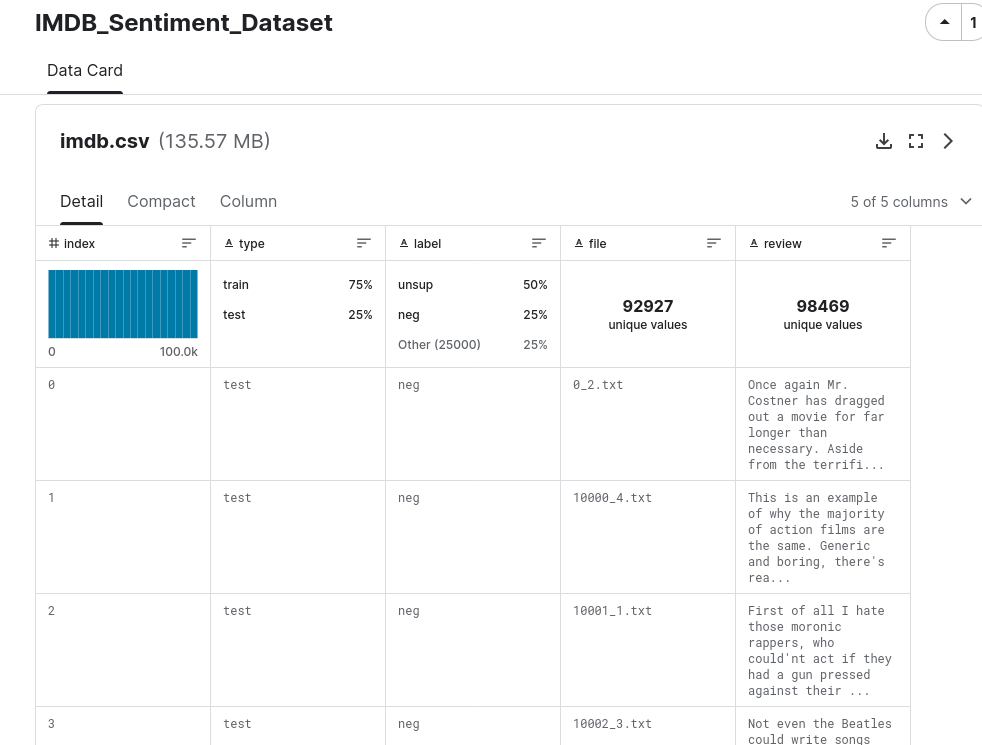

Is prakar csv file me diye data se train and test datasets banana hai.

HALANKI, ABHI IS FILE SE DATASET BANANA, SMJH NHI AAYA, SIR KA CODE KAFI TOUGH THA NEED TO TAKE HELP OF CHATGPT, WHENEVER MEET WITH SUCH KIND OF DATASETS.

In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import pickle

In [2]:
ds_train = tf.data.TextLineDataset("/content/drive/MyDrive/imdb.csv")
ds_test = tf.data.TextLineDataset("/content/drive/MyDrive/imdb.csv")

In [3]:
for line in ds_train.skip(1).take(5): # skip the first row, as it is header only
  print(line)

tf.Tensor(b'0,test,neg,0_2.txt,"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner\'s character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he\'s better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher\'s ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in."', shape=(), dtype=string)
tf.Tensor(b'1,test,neg,10000_4.txt,"T

Rightnow everything is in one byte string.

In [4]:
for line in ds_train.skip(1).take(5): # skip the first row, as it is header only
  print(tf.strings.split(line,","))

tf.Tensor(
[b'0' b'test' b'neg' b'0_2.txt'
 b'"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences'
 b' of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet'
 b" and Costner's character are realized early on"
 b' and then forgotten until much later'
 b' by which time I did not care. The character we should really care about is a very cocky'
 b" overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker"
 b" Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here"
 b' it was all I could do to keep from turning it off an hour in."'], shape=(12,), dtype=s

In [5]:
for line in ds_train.skip(1).take(5): # skip the first row, as it is header only
  print(tf.strings.split(line,",", maxsplit=4)) # so that it won't split the reviews, only first 4 to be splitted

tf.Tensor(
[b'0' b'test' b'neg' b'0_2.txt'
 b'"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner\'s character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he\'s better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher\'s ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in."'], shape=(5,), dtype=string)
tf.Tensor(
[b'1' b'

In [7]:
def filter_train(line):
  split_line = tf.string.split(line,",",maxsplit=4)
  dataset_belonging = split_line[1] # train, test , assume like indeces only
  sentiment_category = split_line[2] # pos, neg, unsup

  return (
      True
      if dataset_belonging == "train" and sentiment_category != 'unsup'
      else False
  )

In [10]:
# exactly same for the test set
def filter_test(line):
  split_line = tf.string.split(line,",",maxsplit=4)
  dataset_belonging = split_line[1] # train, test , assume like indeces only
  sentiment_category = split_line[2] # pos, neg, unsup

  return (
      True
      if dataset_belonging == "test" and sentiment_category != 'unsup'
      else False
  )

In [ ]:
ds_train = tf.data.TextLineDataset("/content/drive/MyDrive/imdb.csv").filter(filter_train)
ds_test = tf.data.TextLineDataset("/content/drive/MyDrive/imdb.csv").filter(filter_test)

In the context you've provided, `ds_train.map(encode_map_fn, num_parallel_calls=AUTOTUNE)` is using the `.map()` function as part of TensorFlow's Dataset API.

In TensorFlow, the `Dataset.map()` function is used to apply a transformation to each element of the dataset. This is commonly used for preprocessing input data, applying augmentations, or any other kind of data manipulation needed before feeding it into a machine learning model.

Here's what each part of `ds_train.map(encode_map_fn, num_parallel_calls=AUTOTUNE)` means:

- `ds_train`: This is a TensorFlow dataset object that you've created, presumably containing your training data.
- `.map()`: This is the method being called on the dataset object to apply a transformation.
- `encode_map_fn`: This is the function that you want to apply to each element of the dataset. It could be any function that takes an input element of the dataset and returns a transformed element.
- `num_parallel_calls=AUTOTUNE`: This argument specifies the level of parallelism to use when applying the transformation. `AUTOTUNE` is a special value that allows TensorFlow to dynamically tune the level of parallelism based on available resources.

So, `ds_train.map(encode_map_fn, num_parallel_calls=AUTOTUNE)` applies the `encode_map_fn` function to each element of `ds_train`, potentially processing multiple elements in parallel for efficiency. This is a common pattern in TensorFlow for preprocessing input data before training a model.

**Get the full code**

In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import pickle

tokenizer = tfds.features.text.Tokenizer()

english = tf.data.TextLineDataset("english.csv")
swedish = tf.data.TextLineDataset("swedish.csv")
dataset = tf.data.Dataset.zip((english, swedish))

for eng, swe in dataset.skip(1):
    print(tokenizer.tokenize(eng.numpy())) # tokenize=splitting or words ko alag alag krna
    print(tokenizer.tokenize(swe.numpy().decode("UTF-8")))

# TODO:
# 1. vocabulary (for each language)
# 2. tokenize and numericalize words
# 3. padded_batch, create model


import sys

sys.exit()


## Example if you have multiple files
file_names = ["test_example1.csv", "test_example2.csv", "test_example3.csv"]
dataset = tf.data.TextLineDataset(file_names)

dataset1 = tf.data.TextLineDataset("test_example1.csv").skip(1)  # .map(preprocess1)
dataset2 = tf.data.TextLineDataset("test_example2.csv").skip(1)  # .map(preprocess1)
dataset3 = tf.data.TextLineDataset("test_example3.csv").skip(1)  # .map(preprocess1)

dataset = dataset1.concatenate(dataset2).concatenate(dataset3)

for line in dataset:
    print(line)


import sys

sys.exit()


def filter_train(line):
    split_line = tf.strings.split(line, ",", maxsplit=4)
    dataset_belonging = split_line[1]  # train, test
    sentiment_category = split_line[2]  # pos, neg, unsup

    return (
        True
        if dataset_belonging == "train" and sentiment_category != "unsup"
        else False
    )


def filter_test(line):
    split_line = tf.strings.split(line, ",", maxsplit=4)
    dataset_belonging = split_line[1]  # train, test
    sentiment_category = split_line[2]  # pos, neg, unsup

    return (
        True if dataset_belonging == "test" and sentiment_category != "unsup" else False
    )


ds_train = tf.data.TextLineDataset("imdb.csv").filter(filter_train)
ds_test = tf.data.TextLineDataset("imdb.csv").filter(filter_test)

# TODO:
# 1. Create vocabulary
# 2. Numericalize text str -> indices (TokenTextEncoder)
# 3. Pad the batches so we can send in to an RNN for example

tokenizer = tfds.features.text.Tokenizer()
# 'i love banana' -> ['i', 'love', 'banana'] -> [0, 1, 2]


def build_vocabulary(ds_train, threshold=200):
    """ Build a vocabulary """
    frequencies = {}
    vocabulary = set()
    vocabulary.update(["sostoken"])
    vocabulary.update(["eostoken"])

    for line in ds_train.skip(1):
        split_line = tf.strings.split(line, ",", maxsplit=4)
        review = split_line[4]
        tokenized_text = tokenizer.tokenize(review.numpy().lower())

        for word in tokenized_text:
            if word not in frequencies:
                frequencies[word] = 1

            else:
                frequencies[word] += 1

            # if we've reached the threshold
            if frequencies[word] == threshold:
                vocabulary.update(tokenized_text)

    return vocabulary


# Build vocabulary and save it to vocabulary.obj
vocabulary = build_vocabulary(ds_train)
vocab_file = open("vocabulary.obj", "wb")
pickle.dump(vocabulary, vocab_file)

# Loading the vocabulary
# vocab_file = open("vocabulary.obj", "rb")
# vocabulary = pickle.load(vocab_file)

encoder = tfds.features.text.TokenTextEncoder(
    list(vocabulary), oov_token="<UNK>", lowercase=True, tokenizer=tokenizer,
)


def my_encoder(text_tensor, label):
    encoded_text = encoder.encode(text_tensor.numpy())
    return encoded_text, label


def encode_map_fn(line):
    split_line = tf.strings.split(line, ",", maxsplit=4)
    label_str = split_line[2]  # neg, pos
    review = "sostoken " + split_line[4] + " eostoken"
    label = 1 if label_str == "pos" else 0

    (encoded_text, label) = tf.py_function(
        my_encoder, inp=[review, label], Tout=(tf.int64, tf.int32),
    )

    encoded_text.set_shape([None])
    label.set_shape([])
    return encoded_text, label


AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(encode_map_fn, num_parallel_calls=AUTOTUNE).cache()
ds_train = ds_train.shuffle(25000)
ds_train = ds_train.padded_batch(32, padded_shapes=([None], ()))

ds_test = ds_test.map(encode_map_fn)
ds_test = ds_test.padded_batch(32, padded_shapes=([None], ()))

model = keras.Sequential(
    [
        layers.Masking(mask_value=0),
        layers.Embedding(input_dim=len(vocabulary) + 2, output_dim=32,),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="relu"),
        layers.Dense(1),
    ]
)

model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(3e-4, clipnorm=1),
    metrics=["accuracy"],
)

model.fit(ds_train, epochs=15, verbose=2)
model.evaluate(ds_test)

we learnt:

 How to load custom dataset of text using TextLineDataset(); also the ways ti make dataset, depending upon the structure of lines in the dataset.

But code nhi smjh aaya hai, bhai chatgpt se help lena, jb same csv file me sab kuch avaulable ho, also you can do using the above code as well. But don't need right now. Jb jarurat padegi tb dekh lenge.

This code seems to be a sentiment analysis task where you're working with IMDb reviews. Let's break down what each section does and identify any potential improvements:

1. **Data Loading and Preprocessing:**
   - You're loading English and Swedish datasets from CSV files using `TextLineDataset`. Then, you're zipping these datasets together.
   - In the loop, you're tokenizing both English and Swedish text using `Tokenizer`.

2. **Building Vocabulary:**
   - There's a function `build_vocabulary` that builds the vocabulary from the training dataset.
   - It counts word frequencies and updates a vocabulary set based on a threshold.
   - It saves the vocabulary to a file using pickle.

3. **Encoding and Mapping:**
   - There's an `encode_map_fn` function that encodes the text and maps it to numerical indices.
   - It uses a custom encoder function (`my_encoder`) that encodes text using a TokenTextEncoder.
   - The `encode_map_fn` is applied to the training and test datasets using `map()`. The `num_parallel_calls` parameter enables parallel processing for efficiency.

4. **Dataset Processing:**
   - Training dataset:
     - It's cached, shuffled, and padded using `padded_batch()`.
   - Test dataset:
     - It's padded using `padded_batch()`.

5. **Model Building and Training:**
   - A simple sequential model is defined with embedding, pooling, and dense layers.
   - The model is compiled with binary cross-entropy loss and Adam optimizer.
   - Model training is done with the training dataset using `fit()`.
   - Model evaluation is done with the test dataset using `evaluate()`.

**Potential Improvements:**
- **Data Handling:** Ensure that the data is correctly preprocessed and loaded. For instance, check if skipping the first line of the CSV files is necessary and handle encoding/decoding properly.
- **Vocabulary Building:** The vocabulary building function seems reasonable, but you might want to experiment with different threshold values to balance vocabulary size and coverage.
- **Model Architecture:** Experiment with different model architectures, especially if your dataset is large and complex. Consider using pre-trained embeddings like Word2Vec or GloVe.
- **Training Parameters:** Experiment with different optimization algorithms, learning rates, batch sizes, and number of epochs to improve model performance.
- **Evaluation:** Besides accuracy, consider other metrics like precision, recall, and F1-score, especially if the classes are imbalanced.

Make sure to test the code thoroughly and iterate on it based on your specific requirements and dataset characteristics.